Data for NVDA For Last 5 years
Latest Volume: 43129744
Yearly Change Percentage:
           close
year            
2019  -22.539521
2020  -54.055917
2021  -55.411241
2022  106.110579
2023  -71.093655
2024  -46.690867
Change over last 5 years: -94.95661605206072


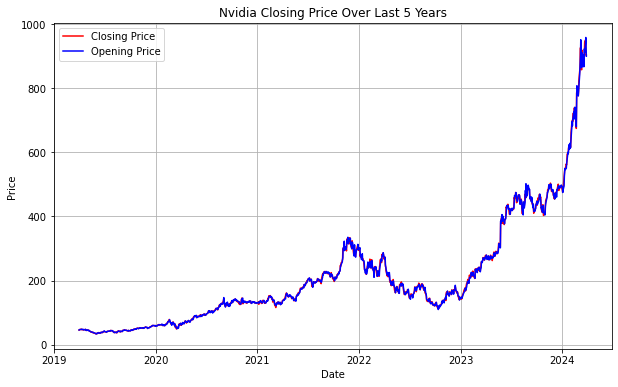

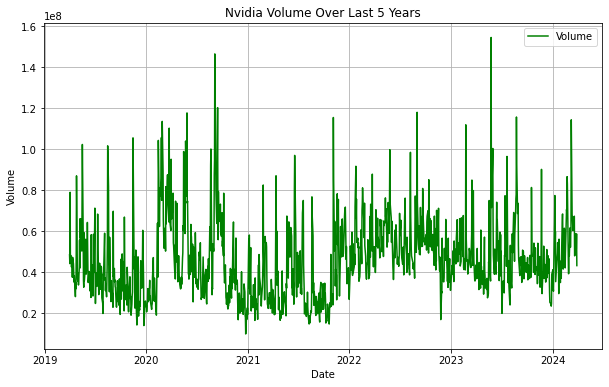

In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# use base python(3.9.12)  
# Nvidia 5 year historical data
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/NVDA?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"

# Fetch data from the endpoint
response = requests.get(endpoint_url)
data = response.json()

# Check if data is fetched successfully
if "historical" in data:
    # Convert data to DataFrame
    df = pd.DataFrame(data["historical"])
    
    
    print("Data for "+data["symbol"]+" For Last 5 years")
    
    # Change over last 5 years 

    change_over_5_years = (df.iloc[-1]['close'] - df.iloc[0]['close']) / df.iloc[0]['close'] * 100
    print("Change over last 5 years:", change_over_5_years)

    # data analysis / visualization 
    

    ## closing and opening price over the years

    plt.figure(figsize=(10, 6))
    # close price
    plt.plot(df['date'], df['close'], label='Closing Price',color='red')
    plt.plot(df['date'], df['open'], label='Opening Price',color='blue')
    plt.title('Nvidia Closing Price Over Last 5 Years')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


    ## volume

    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['volume'], label='Volume', color='green')
    plt.title('Nvidia Volume Over Last 5 Years')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()


else:
    print("Failed to fetch data from the API endpoint.")


# Visualising loaded data


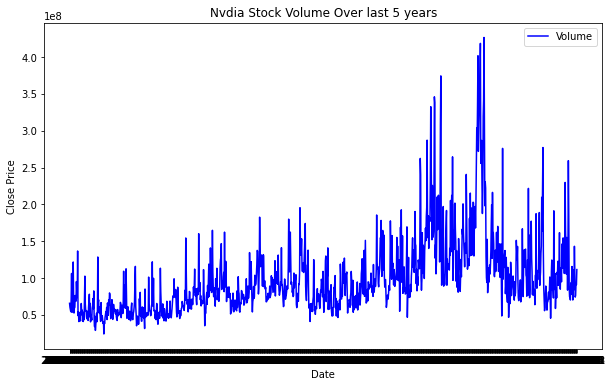

In [6]:

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['volume'], label='Volume', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Nvdia Stock Volume Over last 5 years')
plt.legend()
plt.grid(False)
plt.show()